In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

from sklearn.metrics import mean_squared_error

In [4]:
import xgboost as xgb

In [5]:
xgb.__version__

'1.1.1'

In [6]:
DATA_DIR_PATH = os.path.join('..', '..', 'data')

def laod_data(file_name):
  file_path = os.path.join(DATA_DIR_PATH, file_name)
  return pd.read_csv(file_path, header=0)

In [7]:
df_train = laod_data('bookmark_train_data.csv')
print(len(df_train))
#df_train.head(3)

199


In [9]:
from sklearn.preprocessing import LabelEncoder

cat_le = LabelEncoder()
cat_le.fit(df_train['category'])

WORD_CLASSE_LABELS = ['その他', 'フィラー', '副詞', '助動詞', '助詞',
                     '動詞', '名詞', '形容詞', '感動詞', '接続詞',
                     '接頭詞', '記号', '連体詞',]
new_wc_columns = {}
for (i, name) in enumerate(WORD_CLASSE_LABELS):
    new_wc_columns['wc_sum_{}'.format(name)] = 'wc_sum_{}'.format(i)
    new_wc_columns['wc_rate_{}'.format(name)] = 'wc_rate_{}'.format(i)


def data_preprocess(df):
    new_df = df.drop(['ncode', 'title', 'bookmark_cat'], axis=1)

    new_df['category'] = cat_le.transform(new_df['category'])

    new_df['rating'] = new_df['rating'] * 10
    new_df = new_df.astype({'rating': 'int32'})

    #wc_columns = [col for col in new_df.columns if col.find('wc_') != -1]
    #new_df = new_df.drop(wc_columns, axis=1)
    new_df = new_df.rename(columns=new_wc_columns)

    kw_columns = [col for col in new_df.columns if col.find('kw_') != -1]
    new_df = new_df.drop(kw_columns, axis=1)

    return new_df

In [10]:
df_train.keys()

Index(['ncode', 'title', 'category', 'bookmark_cat', 'created_at',
       'updated_at', 'char_count_sum', 'new_line_count_sum',
       'talk_char_count_sum', 'new_line_count_rate_sum',
       'talk_char_count_rate_sum', 'char_count_avg', 'new_line_count_avg',
       'talk_char_count_avg', 'new_line_count_rate_avg',
       'talk_char_count_rate_avg', 'wc_sum_その他', 'wc_sum_フィラー', 'wc_sum_副詞',
       'wc_sum_助動詞', 'wc_sum_助詞', 'wc_sum_動詞', 'wc_sum_名詞', 'wc_sum_形容詞',
       'wc_sum_感動詞', 'wc_sum_接続詞', 'wc_sum_接頭詞', 'wc_sum_記号', 'wc_sum_連体詞',
       'wc_rate_その他', 'wc_rate_フィラー', 'wc_rate_副詞', 'wc_rate_助動詞',
       'wc_rate_助詞', 'wc_rate_動詞', 'wc_rate_名詞', 'wc_rate_形容詞', 'wc_rate_感動詞',
       'wc_rate_接続詞', 'wc_rate_接頭詞', 'wc_rate_記号', 'wc_rate_連体詞', 'kw_冒険者',
       'kw_魔王', 'kw_日常', 'kw_成り上がり', 'kw_内政', 'kw_恋愛', 'kw_無双', 'kw_青春',
       'kw_ハーレム', 'kw_男主人公', 'kw_奴隷', 'kw_テンプレ', 'kw_勘違い', 'kw_ほのぼの', 'kw_貴族',
       'kw_ギルド', 'kw_コメディ', 'kw_異世界', 'kw_エルフ', 'kw_ファンタジー', 'kw_オリジナル戦記',
       

In [11]:
df_train2 = data_preprocess(df_train)
df_train2.head(3)

,category,created_at,updated_at,char_count_sum,new_line_count_sum,talk_char_count_sum,new_line_count_rate_sum,talk_char_count_rate_sum,char_count_avg,new_line_count_avg,...,wc_rate_4,wc_rate_5,wc_rate_6,wc_rate_7,wc_rate_8,wc_rate_9,wc_rate_10,wc_rate_11,wc_rate_12,rating
0,6,1.586338e+09,1.593468e+09,92340,3840,28950,0.041585,0.313515,3078.0,128.0,...,0.237664,0.226083,0.225076,0.013595,0.006042,0.007049,0.006042,0.144008,0.011078,30
1,6,1.590714e+09,1.593338e+09,77880,4140,4950,0.053159,0.063559,2596.0,138.0,...,0.238590,0.238013,0.217215,0.017909,0.001155,0.010399,0.001155,0.138070,0.013287,40
2,6,1.575176e+09,1.593429e+09,59880,3090,10230,0.051603,0.170842,1996.0,103.0,...,0.240486,0.177328,0.285020,0.014575,0.000000,0.005668,0.008907,0.148178,0.005668,30


In [12]:
X = df_train2.drop(['rating'], axis=1).values
y = df_train2['rating'].values
print(X.shape, y.shape)

(199, 39) (199,)


In [13]:
feature_names = df_train2.keys()[:-1]

In [15]:
#print(feature_names)
#print(len(feature_names))

In [16]:
# print(y)

# u, counts = np.unique(y, return_counts=True)
# print(len(u))
# print(u)
# print(counts)

In [17]:
from imblearn.over_sampling import RandomOverSampler

In [18]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

print(X_resampled.shape, y_resampled.shape)

u, counts = np.unique(y_resampled, return_counts=True)

print(len(u))
print(u)
print(counts)

(915, 39) (915,)
15
[ 5 10 15 17 20 25 30 35 40 45 50 52 60 67 75]
[61 61 61 61 61 61 61 61 61 61 61 61 61 61 61]


In [19]:
from sklearn.model_selection import train_test_split

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.3, shuffle=True, random_state=1)

In [20]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(640, 39) (640,)
(275, 39) (275,)


In [21]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)

In [22]:
#print(dtrain.feature_names)

In [30]:
xgb_params = {
    #'objective': 'reg:linear',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}

evals = [(dtrain, 'train'), (dval, 'eval')]
evals_result = {}

bst = xgb.train(xgb_params,
                dtrain,
                num_boost_round=100,
                early_stopping_rounds=20,
                evals=evals,
                evals_result=evals_result,
                verbose_eval=False)

In [32]:
y_pred = bst.predict(dval)
mse = mean_squared_error(y_val, y_pred)
print('RMSE:', math.sqrt(mse))

RMSE: 6.257003174252576


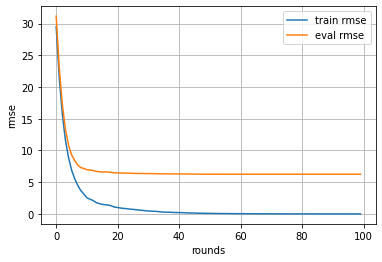

In [33]:
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')

eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')

plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()